# Face2Age
> Predicting someone's age from their face

- toc: false
- branch: master
- badges: true
- comments: true
- author: Jesse van Elteren
- image: images/age_recognition.png
- categories: []

Deep learning has seen incredible results the last couple of year. As long as you have a large enough dataset, it you can transform any input to any output. A couple of examples:

* Image classification, where you map an image to a label (input an image of a frog, computer outputs ‘frog’)
* Sentence generation (if I start a sentence with ‘Today, the weather is’, computer outputs ‘great, let's take a walk’.
* Recommender system (which is the next video that will be most likely to keep the user watching)
As an aside, deep learning is not without it’s ethical problems, for example these social media recommender systems have a [tendency to radicalize people](https://www.nytimes.com/2018/03/10/opinion/sunday/youtube-politics-radical.html), since that maximizes their 'engagement' to the platform. 
 
In this project, I’ve taken on a image regression problem. Given an image of someone’s face, how well can we predict the age of that person? It’s a nice problem, because the answer is not always obvious: some people look older or younger than they really are. By showing the computer model examples and giving feedback how wrong it is on its prediction, the model is improving. We don’t have to explain anything about how an old or young person looks like. Can you imagine how difficult it would be to program how to recognize wrinkles? This is essentially the wonder of neural networks.
 
When training a model, an important part is the performance metric. For this task of guessing someone’s age, I’ve chosen Mean Absolute Error, basically how many years you’ve guessed wrong. A prediction of 12 on an actual age of 10 means the MAE is 2, just as a prediction of 8 also has an MAE of 2.

The dataset contains about 10.000 images, I’ve trained the model on 70% of the dataset. That leaves about 3k images which the model has not seen. We use this to test it’s performance. In theory, this performance will generalize to other unseen images. In practice that remains to be seen, since real life images can be much messier, e.g. in quality, zoom level and background.

Below you can see it getting better over time. The horizontal axis displays how many times we feed the training set to the model. The left graph shows performance on the training set, the right graph on the test set. Initially, it’s off by about 11 years, and slowly converging to a MAE of 2 years. But taking the performance on the training dataset is cheating, we are interested in it’s performance on unseen images! The performance there converges to around 4.2.

![](age/age_training.png)

In [2]:
# hide
import time
import functools
import random
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torch.optim import lr_scheduler, swa_utils
import torchvision
from torchvision.datasets import ImageFolder, DatasetFolder
from torchvision import transforms
from diskcache import Cache

In [1]:
# hide
cache = Cache('.cache/diskcache')
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
PATH = 'data/face_age'


@cache.memoize()
def imgpath_to_normalized_tensor(imgpath):
        # makes a tensor, scales range to 0-1 and normalizes to same as imagenet
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
        img = normalize(transforms.PILToTensor()(Image.open(imgpath)).float()/255)
        return img


class Ageset(Dataset):
    def __init__(self, path, transforms = None, valid=False, split_pct = 0.3):
        self.image_paths = list(Path(path).rglob("*.png"))
        random.seed(42)
        random.shuffle(self.image_paths)
        split_point = int(len(self)*0.3)
        if valid:
            self.image_paths = self.image_paths[:split_point]
            # print('len validation dataset', len(self.image_paths))
        else:
            self.image_paths = self.image_paths[split_point:]
            # print('len train dataset', len(self.image_paths))
    def __len__(self):
        return len(self.image_paths)
    
    def show_image(self,i):
        return Image.open(self.image_paths[i])

    @classmethod # somehow this is needed for diskcache to work properly. Or define the function outside of the class
    @functools.lru_cache(maxsize=None)
    @cache.memoize()
    def imgpath_to_normalized_tensor(cls,imgpath):
            # makes a tensor, scales range to 0-1 and normalizes to same as imagenet
            normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225])
            img = normalize(transforms.PILToTensor()(Image.open(imgpath)).float()/255)
            return img
            
    def __getitem__(self,i):
        if isinstance(i, slice):
            # return [self[n] for n,_ in enumerate(self.image_paths[i])]
            # maybe better to return a new ageset to preserve the functions
            ret = copy.deepcopy(self)
            ret.image_paths = ret.image_paths[i]
            return ret

        return (self.imgpath_to_normalized_tensor(self.image_paths[i]),
                int(self.image_paths[i].parent.name))


NameError: name 'Cache' is not defined

In [3]:
# hide
def construct_tensor_dataset(path, max_len=None):
    # this took 20 GB RAM max
    image_paths = list(Path(path).rglob("*.png"))
    random.shuffle(image_paths)
    if max_len:
        image_paths = image_paths[:max_len]
    
    xs = torch.empty(len(image_paths), 3,200,200)
    print('empty created')
    for i, loc in enumerate(image_paths):
        if i%1000==0: print(i)
        xs[i] = imgpath_to_normalized_tensor(loc)
    torch.save(xs,'data/input/xs')

    print('done')

    ys = torch.stack([torch.Tensor([int(Path(loc).parent.name)]) for loc in image_paths])
    torch.save(ys,'data/input/ys')
    print('done')
    return None
# construct_tensor_dataset(PATH)

In [4]:
# hide
class AgeTensorDataset(TensorDataset):
    def __init__(self, xs, ys, valid=False, split_pct=0.3):
        length = len(xs)
        split = int(xs.shape[0]*split_pct)
        if valid:
            super().__init__(xs[:split],ys[:split])
        else:
            super().__init__(xs[split:],ys[split:])

    def __getitem__(self,x):
        return super().__getitem__(x)

In [5]:
# hide
class AgeResnet(nn.Module):
    def __init__(self, size='18', feat_extract=False):
        super().__init__()
        resnet = 'torchvision.models.resnet'+size+'(pretrained=True)'
        resnet = eval(resnet)
        modules=list(resnet.children())[:-1]
        self.resnet =nn.Sequential(*modules)

        if feat_extract:
            # with feature extraction we only train the linear layer and keep the resnet parameters fixed 
            for m in self.modules():
                m.requires_grad_(False)

        self.fc = nn.Linear(in_features=512, out_features=1, bias=True)
        nn.init.kaiming_normal_(self.fc.weight)

    def forward(self,x):
        out = self.resnet(x)
        x = torch.flatten(out, 1)
        return self.fc(x)

In [6]:
# hide
def determine_size(dataset):
    num_items = len(dataset)
    img_dimensions = list(dataset[0][0].shape)
    bytes_per_fp32 = 4
    bytes_per_gb = 1024**3
    size_in_gb = num_items * int(np.product(img_dimensions)) * bytes_per_fp32 / bytes_per_gb
    print('items in dataset', num_items, 'img_dimensions', img_dimensions, 'size of ds in memory in gb:', size_in_gb)

In [7]:
# hide
def train():
    best_loss = 1000000000
    best_model = None
    not_improve_count = 0
    loss = {'train':[], 'val':[]}

    for epoch in range(NUM_EPOCH):
        print(f'Starting epoch {epoch}')
        start_time = time.time()
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            total_loss = 0
            for data in dls[phase]:
                x, y = data[0].to(DEVICE), data[1].to(DEVICE)
                with torch.set_grad_enabled(phase == 'train'):
                    pred = model(x)
                    loss = loss_fn(y, pred)
                    total_loss += loss * len(y)
                    if phase == 'train':
                        loss.backward()
                        opt.step()
                        opt.zero_grad()
                        if SWA_ENABLED and epoch > SWA_START:
                            swa_model.update_parameters(model)
                            swa_sched.step()
                        elif SCHED_ENABLED:
                            sched.step(loss)
                            writer.add_scalar('lr/scheduler', sched.get_last_lr()[0], epoch)
                        writer.add_scalar('lr/optparamgroup0', opt.param_groups[0]['lr'], epoch)
                writer.add_scalar('batchloss/'+phase, loss, epoch)
            
            writer.add_scalar('loss/'+phase, total_loss/len(dls[phase].dataset), epoch)
    
        if total_loss < best_loss:
            best_loss = total_loss
            best_model = copy.deepcopy(model.state_dict())
            not_improve_count = 0
        else:
            not_improve_count += 1
            if not_improve_count > 76:
                print('early stopping!')
                break
           
        print(f"loss after epoch {epoch} : {total_loss / len(dls['val'].dataset)}")
        writer.add_scalar('time', (time.time()-start_time)/60, epoch)


    if SWA_ENABLED:
        swa_model.to('cpu')
        swa_utils.update_bn(train_dl, swa_model)
        swa_model.to(DEVICE)
        total_loss_train = 0
        total_loss_val = 0

        with torch.no_grad():
            for data in train_dl:
                    x, y = data[0].to(DEVICE), data[1].to(DEVICE)
                    total_loss_train += loss_fn(y, model(x)) * len(y)
            writer.add_scalar('loss/train', total_loss_train/len(train_set), epoch+1)
            swa_model.eval()

            for data in val_dl:
                    x, y = data[0].to(DEVICE), data[1].to(DEVICE)
                    total_loss_val += loss_fn(y, model(x)) * len(y)
            writer.add_scalar('loss/val', total_loss_train/len(val_set), epoch+1)
        swa_model.avg_fn=None
        torch.save(swa_model.state_dict() ,'data/models/'+'swa_model'+str((total_loss_val/len(val_set)).item()))
    torch.save(best_model,'data/models/'+'model'+str((best_loss/len(val_set)).item()))
    writer.flush()
    writer.close()

In [10]:
# hide
# adam works best with lr of 0.001 (tested 0.1 and 0.01)
# adam without scheduler works best
# first it took 6 minutes to load all the datasets. With lru cache it was immediate (6GB memory use). With disk cache it took about 1-2 minutes. Great result. Finally what worked even better is not do any preloading, but just lru_cache getitem. This shaved off the initial preloading 
# feature extraction led to MSE of 12 after 40 epochs. Didnt really work. Maybe unfreeze more
# adam was outperformed in feature extraction, but for finetuning it worked better
# larger bs converges better and runs sligthly faster (about 10%) [512, 256,64,8]
# SWA gives an extreme improvement, from loss 3.7 to 2.7!!, ran 40 epochs, then 15 SWA epochs

# import adabound

def mae_loss(y, pred):
    return (torch.abs(y-pred.T)).mean()
loss_fn = mae_loss

NUM_EPOCH = 40
SWA_START = 40
LR = 0.001
BATCH_SIZE = 512
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
SWA_ENABLED = False
SCHED_ENABLED = False

torch.cuda.empty_cache()
# xs = torch.load('data/input/xs').to(DEVICE)
# ys = torch.load('data/input/ys').to(DEVICE)

# train_set = AgeTensorDataset(xs,ys, valid=False)
train_set = Ageset("data/face_age")
determine_size(train_set)
train_dl = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

# val_set = AgeTensorDataset(xs,ys, valid=True)
val_set = Ageset("data/face_age", valid=True)
determine_size(val_set) 
val_dl = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True)
dls = {'train': train_dl, 'val': val_dl}

feat={True:'feat_ext', False:'finetune'}
opts = {0:'adam',1:'adabound'}

for i in [False]:
    for j in range(1):
        for BATCH_SIZE in [256]:
            for res in [18]:

                torch.cuda.empty_cache()



                writer = SummaryWriter(comment=f'{feat[i]} opt {opts[j]} epoch {NUM_EPOCH} SWA_START {SWA_START} LR BATCH_SIZE {LR}')
                model = AgeResnet(size=str(res), feat_extract=i)
                model = model.to(DEVICE)

                if j ==0:
                    opt = torch.optim.Adam(model.parameters(), LR)
                if j ==1:
                    opt = adabound.AdaBound(model.parameters(), lr=1e-3, final_lr=0.1)


                if SCHED_ENABLED:
                    # if i ==0:
                    #     sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt)
                    #     sched.get_last_lr = lambda: [1]
                    # if i == 1:
                    #     sched = torch.optim.lr_scheduler.OneCycleLR(opt, LR, steps_per_epoch=len(train_dl), epochs=NUM_EPOCH)
                    # if i == 2:
                    sched = torch.optim.lr_scheduler.MultiplicativeLR(opt, lr_lambda=lambda x: 1)
                if SWA_ENABLED:
                    swa_model = swa_utils.AveragedModel(model)
                    swa_sched = swa_utils.SWALR(opt, swa_lr = 0.0005)
                train()

items in dataset 6837 img_dimensions [3, 200, 200] size of ds in memory in gb: 3.0563771724700928
items in dataset 2930 img_dimensions [3, 200, 200] size of ds in memory in gb: 1.309812068939209
Starting epoch 0
loss after epoch 0 : 12.120803833007812
Starting epoch 1
loss after epoch 1 : 8.390729904174805
Starting epoch 2
loss after epoch 2 : 10.963115692138672
Starting epoch 3
loss after epoch 3 : 8.751303672790527
Starting epoch 4
loss after epoch 4 : 6.533456802368164
Starting epoch 5
loss after epoch 5 : 5.988646030426025
Starting epoch 6
loss after epoch 6 : 5.376057147979736
Starting epoch 7
loss after epoch 7 : 4.809545040130615
Starting epoch 8
loss after epoch 8 : 5.354997634887695
Starting epoch 9
loss after epoch 9 : 4.8012542724609375
Starting epoch 10
loss after epoch 10 : 5.545410633087158
Starting epoch 11
loss after epoch 11 : 5.049632549285889
Starting epoch 12
loss after epoch 12 : 4.769824504852295
Starting epoch 13
loss after epoch 13 : 4.643012046813965
Starting e

In [8]:
# hide
def gen_pred_df(model, val_items=None, valid=True):
    model.eval()
    model.to(DEVICE)
    
    val_set = Ageset("data/face_age", valid=valid)[:val_items] if val_items else Ageset("data/face_age", valid=valid)
    data =[(model(x[None].to(DEVICE)).item(),y) for x,y in val_set]
    df = pd.DataFrame(data, columns=['pred', 'actual'])
    df['loss'] = abs(df['pred']-df['actual'])
    df['path'] = val_set.image_paths
    # print(f"MAE, {df['loss'].mean()}, median {df['loss'].median()}")
    return df

In [9]:
# hide
from IPython.display import set_matplotlib_formats
def plot_top_losses(df, valid=True, top_loss=True):
    #plots top 9 of the dataframe
    if top_loss:
        df = df.sort_values('loss', ascending=False)
    else:
        df = df.sample(frac=1)
    set_matplotlib_formats('svg')
    fig,ax = plt.subplots(3,3,figsize=(7,7))
    val_set = Ageset('data/face_age', valid=valid)
    for i, a in enumerate(ax.flat):
        # x,y = Ageset('data/face_age')[i]
        pred = int(df.iloc[i]['pred']) #model(x)
        actual  = df.iloc[i]['actual']
        a.set_ylabel('44')
        a.imshow(val_set.show_image(df.iloc[i].name))
        # print(df.iloc[i].path)
        a.set_title('Actual: ' + str(actual) + ' Model: ' + str(pred), size=10)
        # a.text(200,0, str(pred), size=14)
        # a.text(200,0, df.iloc[i].name, size=8)
        a.axis('off')
    fig.tight_layout() 
    set_matplotlib_formats('png')
    plt.subplots_adjust(wspace=0.1, hspace=0.15)
    return plt

In [10]:
# hide
model = AgeResnet()
model.load_state_dict(torch.load('/ds/data/models/model4.18')) #,map_location=torch.device('cpu')
df = gen_pred_df(model, valid=True)

FileNotFoundError: [Errno 2] No such file or directory: '/ds/data/models/model4.18'

Let's check out predictions on some random images in the test set. In the title the actual age and the predicted age by the model.

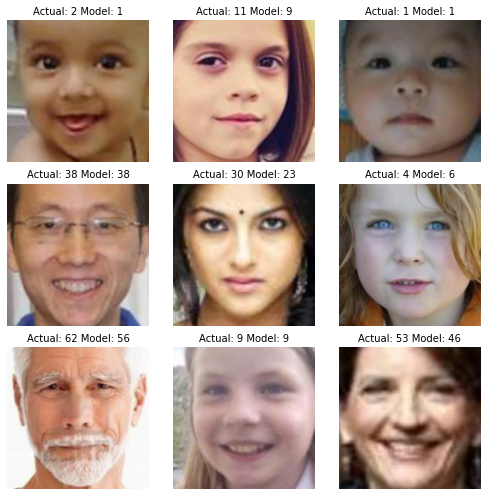

In [65]:
# hide_input
# old
plot = plot_top_losses(df, top_loss=False)
plot.show()

That looks pretty good! To take a more general approach, let's plot the all the images from the test set in a graph.

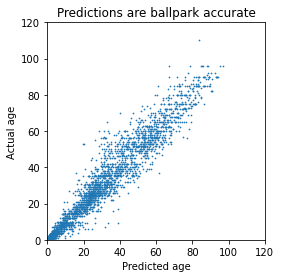

In [66]:
# hide_input
plt.scatter(df['pred'],df['actual'], s=0.5)
plt.figsize=(10,10)
plt.axis([0,120, 0, 120])
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Predictions are ballpark accurate')
plt.xlabel('Predicted age')
plt.ylabel('Actual age');

There are definately some errors, but overall it seems reasonable. It's also interesting to plot the faces where the error was largest.

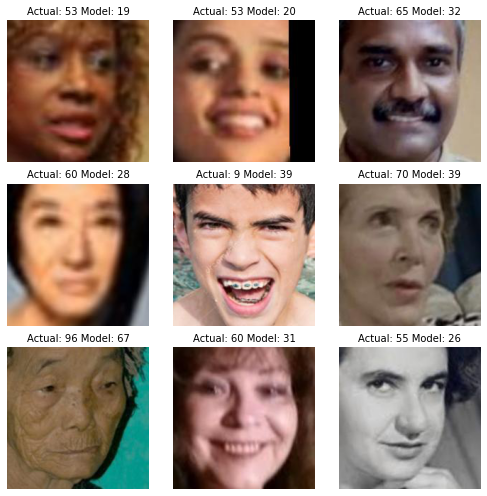

In [67]:
# hide_input
plot_top_losses(df,valid=True).show()

In [20]:
# hide
rm = ['data/face_age/005/2547.png',
'data/face_age/001/3829.png',
'data/face_age/069/8150.png',
'data/face_age/001/5497.png',
'data/face_age/001/4313.png',
'data/face_age/021/8242.png',
'data/face_age/070/1536.png',
'data/face_age/001/7326.png',
'data/face_age/021/1634.png',
'data/face_age/008/7254.png']
for f in rm:
    print(f)
    os.unlink(Path(f))

data/face_age/005/2547.png


FileNotFoundError: [Errno 2] No such file or directory: 'data/face_age/005/2547.png'

In most of the cases the model was simply off, but there are also faces which look much older or younger, or very blurry ones. Which highlights the importance of understanding the dataset and potentially removing outliers from it.

Another approach is to visualize the average error by age.

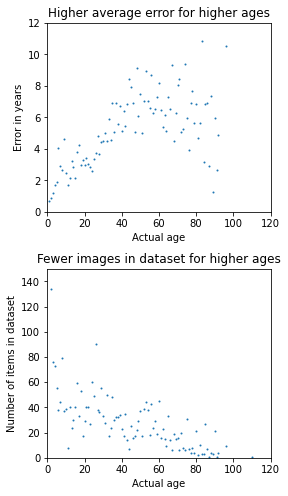

In [73]:
# hide_input
set_matplotlib_formats('png')
 
group = df.groupby(['actual']).agg(['count','mean'])
fig,ax = plt.subplots(2,1,figsize=(4,8))
ax[0].scatter(group.index, group['loss']['mean'], s=1)
ax[0].set_title('Higher average error for higher ages')
ax[1].scatter(group.index, group['loss']['count'], s=1)
ax[0].axis([0,120, 0, 12])
ax[1].set_title('Fewer images in dataset for higher ages')
ax[0].set_xlabel("Actual age")
ax[0].set_ylabel("Error in years")
ax[1].set_ylabel("Number of items in dataset")
ax[1].set_xlabel("Actual age");
ax[1].axis([0,120, 0, 150])
plt.subplots_adjust(wspace=0.2, hspace=0.3)


In [ ]:
# hide
# #launch tensorboard
python -m tensorboard.main --logdir=runs --host=0.0.0.0 --port=6006

In [75]:
# hide
def save_preds_for_app(df):
    df['pred']= df['pred'].astype(int)
    df['path']= df['path'].astype(str)
    # saving something as pickle file
    import pickle
    with open('app/models/predictions.pickle', 'wb') as handle:
        pickle.dump(df, handle, protocol=pickle.HIGHEST_PROTOCOL)
save_preds_for_app(df)     

The error gets larger as someone gets older, which makes perfect sense: when you see a baby you are not going to guess wrong by more then 5 years, but for someone age 50 that is more difficult. 

You could argue for a slight improvement in the predictions with ages > 60, but it could also be an anomaly. There are few really old faces in the dataset, which could be of influence. There are also 300 images of babies age 0 in the dataset, which I removed from the second chart to have a better visualisation.

I’ve build a [webpage](http://35.206.67.46/) where you can try out if you can beat the computer, or even upload a selfie for fun to see how old the computer thinks you are. 

Please take the results with a grain of salt. I’ve taken some selfies and the computer estimated me around 27 to 42, which is ballpark accurate. But an condolence card of my grandmother age 92 was classified as 62. She did look young, but 62 was an underestimation.

I’ve had much fun with this project. I hope you like it as well and will [try out the app](http://35.206.67.46/).

> Note: Technical details on how it was build: Pytorch, Pretrained resnet-18 model. Application runs on Google Cloud Platform, with a Nginx and Gunicorn running in Docker container. Python backend in Fastapi. Code available on [Github](https://github.com/jvanelteren/age_prediction), dataset on [Kaggle](https://www.kaggle.com/frabbisw/facial-age)

In [11]:
from io import BytesIO
from PIL import Image, ImageOps
from functools import partial
from io import BytesIO
from PIL import Image, ImageOps

model = AgeResnet()
model.load_state_dict(torch.load('app/models/model4.18',map_location=torch.device('cpu')))
model.eval()


AgeResnet(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [252]:

def img_to_reshaped_normalized_tensor(img, test=False):
        # makes a tensor, scales range to 0-1 and normalizes to same as imagenet
        # ImageOps.exif_transpose(image)
        exif = img.getexif()
        for k in exif.keys():
                if k != 0x0112:
                        exif[k] = None # If I don't set it to None first (or print it) the del fails for some reason. 
                        del exif[k]
        # Put the new exif object in the original image
        new_exif = exif.tobytes()
        img.info["exif"] = new_exif



        fit = partial(ImageOps.fit, size=(200,200), method=5, bleed=0.0, centering=(0.5, 0.5))
        if test:
                print(img.size)
                return ImageOps.exif_transpose(fit(img))
        # return fit(img)
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])

        return normalize(transforms.functional.pil_to_tensor(ImageOps.exif_transpose(fit(img))).float()/255)

def img_to_reshaped_normalized_tensorold(img, pad=False, crop=False):
        # makes a tensor, scales range to 0-1 and normalizes to same as imagenet
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
        resize = transforms.Resize((200,200), interpolation=0)
    
        if pad: 
                img = ImageOps.expand(img, padding)
                w,h = img.size
                delta_w = max((h,w)) - w
                delta_h = max((h,w)) - h
                padding = (delta_w//2, delta_h//2, delta_w-(delta_w//2), delta_h-(delta_h//2))
        if crop: 
                img = ImageOps.fit(img, size=(200,200), method=5, bleed=0.0, centering=(0.5, 0.5))
        img = resize(img)

        img = transforms.functional.pil_to_tensor(img)
        img = normalize(img.float()/255)
        
        return img

In [247]:
def testrun(test_img, correct = None, test=False,pad=False, crop=False):
    test_img = sorted(test_img)
    if not correct:
        correct = [68]*5+[37]*7
    error = 0
    for i, img in enumerate(test_img):
    
        image = Image.open(img)
        pred = model(img_to_reshaped_normalized_tensorold(image,test,pad, crop)[None]).item()
        
        # print(img, correct[i],round(pred), abs(round(pred)-correct[i]))
        error += abs(round(pred)-correct[i])
    print('MAE', error/len(correct))


In [253]:
from pathlib import Path
correct = [37,37,37,6,6,68,68,68,68,68,37,37,37,37,37,37]
start = time.time()
# test_img = list(Path('/ds/data/testsize/small').rglob("*"))
# testrun(test_img)
# test_img = list(Path('/ds/data/testsize/medium').rglob("*"))
# testrun(test_img)
# test_img = list(Path('/ds/data/testsize/large').rglob("*"))
# testrun(test_img)
correct = [37,37,37,6,6,68,68,68,68,68,37,37,37,37,37,37]
test_img = list(Path('/ds/data/test').rglob("*"))
testrun(test_img, correct=correct)
print(time.time()-start)

MAE 9.5
1.0626757144927979


In [227]:
correct = [37,37,37,6,6,68,68,68,68,68,37,37,37,37,37,37]
start = time.time()
test_img = list(Path('/ds/data/testsize/small').rglob("*"))
testrun(test_img, pad=True)
test_img = list(Path('/ds/data/testsize/medium').rglob("*"))
testrun(test_img, pad=True)
test_img = list(Path('/ds/data/testsize/large').rglob("*"))
testrun(test_img, pad=True)
correct = [37,37,37,6,6,68,68,68,68,68,37,37,37,37,37,37]
test_img = list(Path('/ds/data/test').rglob("*"))
testrun(test_img, correct=correct, pad=True)
print(time.time()-start)

MAE 10.166666666666666
MAE 10.333333333333334
MAE 10.166666666666666
MAE 10.375
3.3058457374572754


In [232]:
image = Image.open('/ds/data/test/oma1.JPG')
pred = model(img_to_reshaped_normalized_tensorold(image, pad=False)[None]).item()
pred
# img = img_to_reshaped_normalized_tensorold(image, test=True)
pred2 = model(img_to_reshaped_normalized_tensorold(image, pad=True)[None]).item()
pred, pred2

(56.43965530395508, 60.182621002197266)

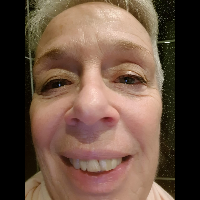

In [234]:
image = Image.open('/ds/data/test/jesse.JPG')
img_to_reshaped_normalized_tensorold(image, test=True,pad=True)

In [217]:
w,h = image.size

delta_w = max((h,w)) - w
delta_h = max((h,w)) - h
padding = (delta_w//2, delta_h//2, delta_w-(delta_w//2), delta_h-(delta_h//2))
new_im = ImageOps.expand(image, padding)
# new_im

In [183]:
image.size

(640, 481)

(640, 481)


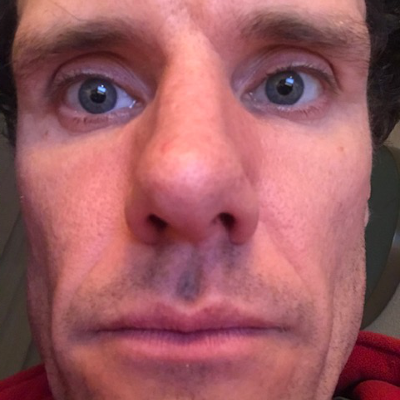

In [96]:
def img_to_reshaped_normalized_tensor(img, test=False):
        # makes a tensor, scales range to 0-1 and normalizes to same as imagenet
        # ImageOps.exif_transpose(image)
        exif = img.getexif()
        for k in exif.keys():
                if k != 0x0112:
                        exif[k] = None # If I don't set it to None first (or print it) the del fails for some reason. 
                        del exif[k]
        # Put the new exif object in the original image
        new_exif = exif.tobytes()
        img.info["exif"] = new_exif



        fit = partial(ImageOps.fit, size=(400,400), method=5, bleed=0.0, centering=(0.5, 0.5))
        if test:
                print(img.size)
                return ImageOps.exif_transpose(fit(img))
        # return fit(img)
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])

        return normalize(transforms.functional.pil_to_tensor(ImageOps.exif_transpose(fit(img))).float()/255)
image = Image.open('/ds/data/test/jesse1.JPG')

img_to_reshaped_normalized_tensor(image, test=True)

In [229]:
correct = [37,37,37,6,6,68,68,68,68,68,37,37,37,37,37,37]
test_img = list(Path('/ds/data/test').rglob("*"))
testrun(test_img, correct=correct)

/ds/data/test/jesse1.JPG 37 37 0
/ds/data/test/jesse2.JPG 37 49 12
/ds/data/test/jesse3.JPG 37 39 2
/ds/data/test/juna1.jpg 6 5 1
/ds/data/test/juna3.jpg 6 7 1
/ds/data/test/oma1.JPG 68 56 12
/ds/data/test/oma2.jpg 68 60 8
/ds/data/test/oma3.JPG 68 50 18
/ds/data/test/oma4.JPG 68 55 13
/ds/data/test/oma5.JPG 68 46 22
/ds/data/test/renske1.jpg 37 38 1
/ds/data/test/renske2.jpg 37 44 7
/ds/data/test/renske3.jpg 37 47 10
/ds/data/test/renske4.jpg 37 19 18
/ds/data/test/renske5.jpg 37 18 19
/ds/data/test/renske6.jpg 37 29 8
MAE 9.5


In [230]:
correct = [37,37,37,6,6,68,68,68,68,68,37,37,37,37,37,37]
test_img = list(Path('/ds/data/test').rglob("*"))
testrun(test_img, correct=correct,pad=True)

/ds/data/test/jesse1.JPG 37 23 14
/ds/data/test/jesse2.JPG 37 35 2
/ds/data/test/jesse3.JPG 37 19 18
/ds/data/test/juna1.jpg 6 12 6
/ds/data/test/juna3.jpg 6 10 4
/ds/data/test/oma1.JPG 68 60 8
/ds/data/test/oma2.jpg 68 67 1
/ds/data/test/oma3.JPG 68 51 17
/ds/data/test/oma4.JPG 68 48 20
/ds/data/test/oma5.JPG 68 51 17
/ds/data/test/renske1.jpg 37 48 11
/ds/data/test/renske2.jpg 37 48 11
/ds/data/test/renske3.jpg 37 54 17
/ds/data/test/renske4.jpg 37 46 9
/ds/data/test/renske5.jpg 37 28 9
/ds/data/test/renske6.jpg 37 39 2
MAE 10.375
